In [15]:
import os
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, concatenate, Input
from tensorflow.keras.models import Model

In [16]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
def build_unet(input_shape):
    inputs = Input(input_shape)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    
    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
        
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    
    model = Model(inputs, outputs, name="UNET")
    return model


In [17]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
if __name__ == "__main__":
    input_shape = (256, 256, 3)
    model = build_unet(input_shape)
    model.summary()

Model: "UNET"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 256, 256, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 256, 256, 64) 256         conv2d_38[0][0]                  
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 256, 256, 64) 36928       batch_normalization_36[0][0]     
_______________________________________________________________________________________________

In [18]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

In [19]:
""" Global parameters """
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
H = 256
W = 256
smooth = 1.

In [20]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [21]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
def load_dataset(path, split=0.2):
    images = sorted(glob(os.path.join(path, "images", "*.png")))
    masks = sorted(glob(os.path.join(path, "masks", "*.png")))

    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [22]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (h, w)
    x = cv2.resize(x, (W, H))   ## (h, w)
    x = x / 255.0               ## (h, w)
    x = x.astype(np.float32)    ## (h, w)
    x = np.expand_dims(x, axis=-1)## (h, w, 1)
    return x

In [23]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y


def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset


In [24]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
augmentation_args = dict(
    rotation_range=0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

image_datagen = ImageDataGenerator(**augmentation_args)
mask_datagen = ImageDataGenerator(**augmentation_args)


In [25]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
def read_and_augment_image(image_path):
    image = read_image(image_path)
    augmented_image = image_datagen.random_transform(image)
    return augmented_image

def read_and_augment_mask(mask_path):
    mask = read_mask(mask_path)
    augmented_mask = mask_datagen.random_transform(mask)
    return augmented_mask

def tf_parse_augmented(x, y):
    def _parse_augmented(x, y):
        x = read_and_augment_image(x)
        y = read_and_augment_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse_augmented, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset_augmented(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse_augmented)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset


In [26]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def loss(y_true, y_pred):
    return -(0.4*dice_coef(y_true, y_pred)+0.6*iou_coef(y_true, y_pred))

In [27]:
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# config.log_device_placement = True
# sess = tf.compat.v1.Session(config=config)

# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.6  # 0.6 sometimes works better for folks
# keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("files")

    """ Hyperparameters """
    batch_size = 16
    lr = 1e-4
    num_epochs = 500
    model_path = os.path.join("files", "model.h5")
    csv_path = os.path.join("files", "log.csv")

    """ Dataset """
    dataset_path = "/home/akshatt/nandan/dataset/dataset/archive/"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y)}")
    print(f"Test : {len(test_x)} - {len(test_y)}")
    
    train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
#     valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)
    
#     train_dataset = tf_dataset_augmented(train_x, train_y, batch=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

    """ Model """
    model = build_unet((H, W, 3))
    model.compile(loss=loss, optimizer=Adam(lr), metrics=[dice_coef, iou_coef])

    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=False),
    ]

    history = model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=callbacks
    )


Train: 1840 - 1840
Valid: 612 - 612
Test : 612 - 612
Epoch 1/500
115/115 [==============================] - 33s 270ms/step - loss: -0.0655 - dice_coef: 0.0884 - iou_coef: 0.0502 - val_loss: -0.0119 - val_dice_coef: 0.0174 - val_iou_coef: 0.0081

Epoch 00001: val_loss improved from inf to -0.01186, saving model to files/model.h5
Epoch 2/500
115/115 [==============================] - 31s 267ms/step - loss: -0.1371 - dice_coef: 0.1722 - iou_coef: 0.1136 - val_loss: -0.0237 - val_dice_coef: 0.0335 - val_iou_coef: 0.0171

Epoch 00002: val_loss improved from -0.01186 to -0.02370, saving model to files/model.h5
Epoch 3/500
115/115 [==============================] - 31s 266ms/step - loss: -0.1931 - dice_coef: 0.2066 - iou_coef: 0.1841 - val_loss: -0.0238 - val_dice_coef: 0.0344 - val_iou_coef: 0.0167

Epoch 00003: val_loss improved from -0.02370 to -0.02378, saving model to files/model.h5
Epoch 4/500
115/115 [==============================] - 31s 266ms/step - loss: -0.2367 - dice_coef: 0.2221 


Epoch 00031: val_loss did not improve from -0.72364

Epoch 00031: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
Epoch 32/500
115/115 [==============================] - 31s 266ms/step - loss: -0.8265 - dice_coef: 0.8911 - iou_coef: 0.7835 - val_loss: -0.7210 - val_dice_coef: 0.8050 - val_iou_coef: 0.6643

Epoch 00032: val_loss did not improve from -0.72364
Epoch 33/500
115/115 [==============================] - 31s 267ms/step - loss: -0.8283 - dice_coef: 0.8923 - iou_coef: 0.7857 - val_loss: -0.7198 - val_dice_coef: 0.8040 - val_iou_coef: 0.6628

Epoch 00033: val_loss did not improve from -0.72364
Epoch 34/500
115/115 [==============================] - 31s 267ms/step - loss: -0.8292 - dice_coef: 0.8929 - iou_coef: 0.7866 - val_loss: -0.7200 - val_dice_coef: 0.8041 - val_iou_coef: 0.6631

Epoch 00034: val_loss did not improve from -0.72364
Epoch 35/500
115/115 [==============================] - 31s 266ms/step - loss: -0.8300 - dice_coef: 0.8936 - iou_coef: 0.7877 - 

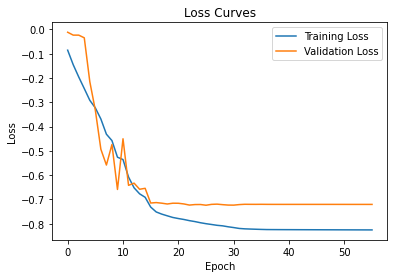

In [28]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


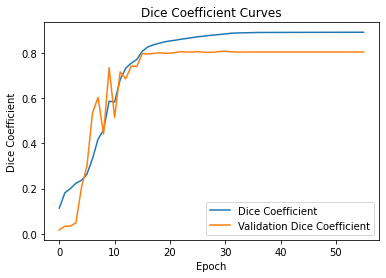

In [29]:
plt.plot(history.history['dice_coef'], label='Dice Coefficient')
plt.plot(history.history['val_dice_coef'], label='Validation Dice Coefficient')
plt.title('Dice Coefficient Curves')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()


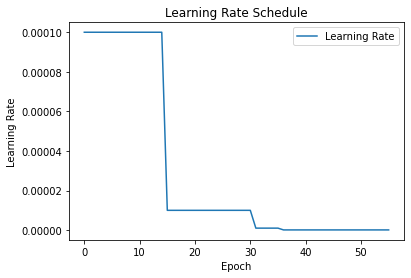

In [30]:
plt.plot(history.history['lr'], label='Learning Rate')
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()
plt.show()


In [31]:
from tqdm import tqdm
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score

In [32]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"


""" Creating a directory """

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def save_results(image, mask, y_pred, save_image_path):
    mask = np.expand_dims(mask, axis=-1)
    mask = np.concatenate([mask, mask, mask], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)
    y_pred = y_pred * 255

    line = np.ones((H, 10, 3)) * 255

    cat_images = np.concatenate([image, line, mask, line, y_pred], axis=1)
    cv2.imwrite(save_image_path, cat_images)

In [33]:
import pandas as pd
if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("results")

    """ Load the model """
    with CustomObjectScope({'loss': loss, 'dice_coef': dice_coef, 'iou_coef': iou_coef}):
        model = tf.keras.models.load_model(os.path.join("files", "model.h5"))

    """ Dataset """
    dataset_path = "/home/akshatt/nandan/dataset/dataset/archive/"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

    """ Prediction and Evaluation """
    SCORE = []
    for x, y in tqdm(zip(test_x, test_y), total=len(test_y)):
        """ Extracting the name """
        name = x.split("/")[-1]

        """ Reading the image """
        image = cv2.imread(x, cv2.IMREAD_COLOR) ## [H, w, 3]
        image = cv2.resize(image, (W, H))       ## [H, w, 3]
        x = image/255.0                         ## [H, w, 3]
        x = np.expand_dims(x, axis=0)           ## [1, H, w, 3]

        """ Reading the mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (W, H))

        """ Prediction """
        y_pred = model.predict(x, verbose=0)[0]
        y_pred = np.squeeze(y_pred, axis=-1)
        y_pred = y_pred >= 0.5
        y_pred = y_pred.astype(np.int32)

        """ Saving the prediction """
        save_image_path = os.path.join("results", name)
        save_results(image, mask, y_pred, save_image_path)

        """ Flatten the array """
        mask = mask/255.0
        mask = (mask > 0.5).astype(np.int32).flatten()
        y_pred = y_pred.flatten()

        """ Calculating the metrics values """
        f1_value = f1_score(mask, y_pred, labels=[0, 1], average="binary")
        jac_value = jaccard_score(mask, y_pred, labels=[0, 1], average="binary")
        recall_value = recall_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
        precision_value = precision_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
        y_pred = y_pred.astype(np.float32)
        mask = mask.astype(np.float32).flatten()
        dice_value = dice_coef(mask, y_pred)
        SCORE.append([name, f1_value, jac_value, recall_value, precision_value, dice_value])

    """ Metrics values """
    score = [s[1:]for s in SCORE]
    score = np.mean(score, axis=0)
    print(f"F1: {score[0]:0.5f}")
    print(f"Jaccard: {score[1]:0.5f}")
    print(f"Recall: {score[2]:0.5f}")
    print(f"Precision: {score[3]:0.5f}")
    print(f"dice_value: {score[4]:0.5f}")

    df = pd.DataFrame(SCORE, columns=["Image", "F1", "Jaccard", "Recall", "Precision", "Dice_value"])
    df.to_csv("files/score.csv")


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 612/612 [00:52<00:00, 11.74it/s]

F1: 0.76711
Jaccard: 0.67694
Recall: 0.78917
Precision: 0.79275
dice_value: 0.76746
